# <img src="./assets/anpl_solo_logo.png" style="height:50px;display:inline"> DDS 0970252 - Autonomous Planning Under Uncertainty
---

**Moshe Rafaeli** - [moshiktech@gmail.com](mailto:moshiktech@gmail.com) \
**Tamir Shazman** - [tmyr@campus.technion.ac.il](mailto:tmyr@campus.technion.ac.il)

Course website: https://anpl-technion.github.io/Teaching/#POMDP \
Course forum and announcements: https://piazza.com/technion.ac.il/fall2025/0970252


## <img width="48" height="48" src="https://img.icons8.com/external-vectorslab-outline-color-vectorslab/53/external-51-science-and-experiments-vectorslab-outline-color-vectorslab.png" alt="external-51-science-and-experiments-vectorslab-outline-color-vectorslab" style="transform:rotate(90deg);"/> Tutorial 3: MDP, POMDP, Open and Close Loop 

---

**Notebook kernel:** `Julia` (recommended version ≥ 1.11)

**Packages used (install if needed):**

In [1]:
using Pkg
Pkg.add(["Distributions", "LinearAlgebra", "Random", "Statistics", "Plots", "StatsBase", "Combinatorics", "POMDPs", "QuickPOMDPs", "POMDPTools"])

   Resolving package versions...
  No Changes to `C:\Users\moshi\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\moshi\.julia\environments\v1.11\Manifest.toml`


In [2]:
using Distributions, LinearAlgebra, Random, Statistics, Plots, StatsBase, Combinatorics, POMDPs, QuickPOMDPs, POMDPTools

### Markov Decision Process (MDP)

---



MDP is defined by the tuple: $ \langle \mathcal{X}, \mathcal{A}, \mathbb{P}_{T}, r, \gamma \rangle $

- $\mathcal{X}$ is the state space
- $\mathcal{A}$ is the action set
- $\mathbb{P}_{T}(x' \mid x, a)$ is the transition (motion) model
- $r(x,a)$ is the reward function for applying action $a$ at state $x$
    - Alternatively: $c(x,a)$ is the _cost_ function for applying action $a$ at state $x$
- $\gamma \in [0, 1]$ is the discount factor

This model assumes the agent can observe it's true state $X_t$ at every time step $t$, the agent performs actions $a_t$ and receives (or calculates) rewards $r_t$ based on the states and actions.

![MDP Illustration](./assets/mdp_illustration.png)

#### Example: Random Walk towards a goal


An agent walks on a 1D axis and aims to stay as close to a pre-defined goal $x^\text{goal}$. \
The states are the agent locations $X_k$, with a state space $\mathcal{X}=\mathbb{R}$. \
The agent can walk right ($a^{\text{right}}=+1$) or left ($a^{\text{left}}=-1$), but the transition noise is normal with std $\sigma_T=0.5$.


In [3]:
# Define the 1D continuous MDP
σ_T = 0.5
goal = 10.0

random_walk_mdp = QuickMDP(
    statetype      = Float64,                       # Continuous 1D
    actions        = [-1.0, 1.0],                   # random walk action: Left or Right
    transition     = (s, a) -> Normal(s + a, σ_T),  # transion model: s' = s + a + noise
    reward         = (s, a) -> -abs(s - goal),      # reward: negative distance to goal
    initialstate   = Deterministic(0.0)             # Start at position 0.0
);


In [4]:
Random.seed!(0970252)

# Run the MDP
s = rand(initialstate(random_walk_mdp))
T = 100
xs = [s]
rs_random_walk = []
r_cumul = 0.0
for t in 1:T
    a = rand(actions(random_walk_mdp))
    sp, r = @gen(:sp, :r)(random_walk_mdp, s, a)
    @show t, s, a, sp, r

    s = sp
    r_cumul += r
    push!(xs, sp)
    push!(rs_random_walk, r_cumul)
end

(t, s, a, sp, r) = (1, 0.0, -1.0, -1.0892456732825797, -10.0)
(t, s, a, sp, r) = (2, -1.0892456732825797, -1.0, -0.8083389156519207, -11.08924567328258)
(t, s, a, sp, r) = (3, -0.8083389156519207, 1.0, 0.1611614087172557, -10.808338915651921)
(t, s, a, sp, r) = (4, 0.1611614087172557, 1.0, 1.2580387099418249, -9.838838591282745)
(t, s, a, sp, r) = (5, 1.2580387099418249, -1.0, 0.0981206693254662, -8.741961290058175)
(t, s, a, sp, r) = (6, 0.0981206693254662, -1.0, -0.8730667949053886, -9.901879330674534)
(t, s, a, sp, r) = (7, -0.8730667949053886, 1.0, 0.24979866563003927, -10.87306679490539)
(t, s, a, sp, r) = (8, 0.24979866563003927, -1.0, -0.3335435578999995, -9.750201334369962)
(t, s, a, sp, r) = (9, -0.3335435578999995, -1.0, -1.4733731285068539, -10.333543557899999)
(t, s, a, sp, r) = (10, -1.4733731285068539, -1.0, -2.310561509554038, -11.473373128506854)
(t, s, a, sp, r) = (11, -2.310561509554038, 1.0, -0.7300986473056162, -12.310561509554038)
(t, s, a, sp, r) = (12, -0.7300986

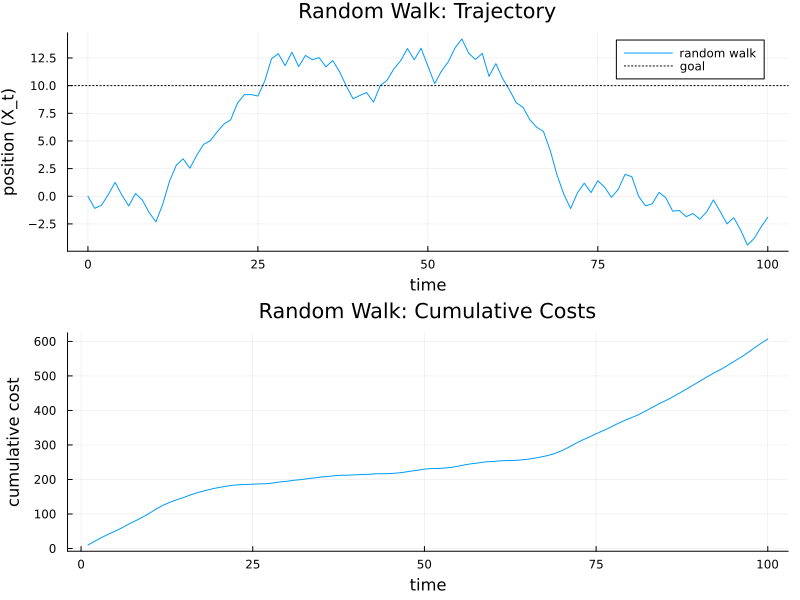

In [5]:
# Plots: position trajectories and costs
p1 = plot(0:T, xs, label="random walk")
hline!(p1, [goal], linestyle=:dot, color=:black, label="goal")
xlabel!(p1, "time"); ylabel!(p1, "position (X_t)"); title!(p1, "Random Walk: Trajectory")

p2 = plot(1:T, -rs_random_walk, label=false) # negative rewards represent costs
xlabel!(p2, "time"); ylabel!(p2, "cumulative cost"); title!(p2, "Random Walk: Cumulative Costs")

plot(p1, p2, layout=(2,1), size=(800,600))

### Partially Observable Markov Decision Process (POMDP)

---


POMDP is defined by the tuple: $ \langle \mathcal{X}, \mathcal{A}, \mathcal{Z}, \mathbb{P}_{0}, \mathbb{P}_{T}, \mathbb{P}_{Z}, r, \gamma \rangle $

- $\mathcal{X}$ is the states space
- $\mathcal{A}$ is the action set
- **$\mathcal{Z}$ is the observation space**
- **$\mathbb{P}_{0}(x)$ is the prior distribution (_belief_)**
- $\mathbb{P}_{T}(x' \mid x, a)$ is the transition (motion) model
- **$\mathbb{P}_{Z}(z \mid x)$ is the observation model**
- $r(x,a)$ is the reward function for performing action $a$ at state $x$
    - Alternatively: $c(x,a)$ is the _cost_ function for performing action $a$ at state $x$
- $\gamma \in [0, 1]$ is the discount factor



POMDP is an MDP with _hidden states_. The agent does not know their actual state $x$, instead they maintain a posterior distribution over what their state could be, according to the information they acquire. \
This is defined as the **_belief_** of the agent at time $t$:
$$
b_t = b[x_t] = \mathbb{P}(x_t \mid H_t),
$$
where $H_t = \{ a_{0:t-1}, z_{1:t} \}$ represents the information (or history) the agent acquired up to time $t$.

In a smoothing formulation, the belief is over the entire state sequence up to time $t$:
$$
b_{0:t} = b[x_{0:t}] = \mathbb{P}(x_{0:t} \mid H_t) = \mathbb{P}(x_{0}, x_{1}, ..., x_{t} \mid H_t),
$$

![POMDP Example](./assets/pomdp_illustration.png)

#### Belief Propagation

Starting with prior belief $b_0$, at each time step $t=0,1,2,...$ the agent selects an action $a_t$, transitions to the next state (according to $\mathbb{P}_T$), then acquires an observation $z_{t+1}$ (according to $\mathbb{P}_{Z}$). \
Each time step the posterior belief of the agent is updated with the new information via the _Bayes filter_ $b_{t+1} = \psi(b_t,a_t,z_{t+1})$.

**Reminder: _Bayes Filter_**
$$
\forall x_{t+1} \in \mathcal{X}: \quad b[x_{t+1}] = \frac{\mathbb{P}(z_{t+1} \mid x_{t+1}) \cdot \int_{x_{t}} \mathbb{P}(x_{t+1} \mid x_{t}, a_{t}) \cdot b[x_{t}] dx_{t}}{\mathbb{P}(z_{t+1} \mid b_{t}, a_{t})}
.
$$


#### POMDP Example: Tiger Problem


In [6]:
tiger_pomdp = QuickPOMDP(
    actions = [:OpenLeft, :OpenRight, :Listen],
    states = [:TigerLeft, :TigerRight],
    observations = [:HearLeft, :HearRight],

    # Defining the transition model
    transition = function (s, a)
        if a == :Listen
            return Deterministic(s) # tiger stays behind the same door
        else # a door is opened
            return POMDPTools.Uniform([:TigerLeft, :TigerRight]) # reset tiger location
        end
    end,

    # Defining the observation model
    observation = function (a, sp)
        if a == :Listen
            if sp == :TigerLeft
                return SparseCat([:HearLeft, :HearRight], [0.85, 0.15]) # sparse categorical
            else
                return SparseCat([:HearRight, :HearLeft], [0.85, 0.15])
            end
        else
            return POMDPTools.Uniform([:HearLeft, :HearRight])
        end
    end,

    # Defining the reward function
    reward = function (s, a)
        if a == :Listen
            return -1.0
        elseif ( s == :TigerLeft && a == :OpenLeft ) || ( s == :TigerRight && a == :OpenRight ) # found the tiger
            return -100.0
        else # escaped from the tiger
            return 10.0
        end
    end,

    initialstate = POMDPTools.Uniform([:TigerLeft, :TigerRight]),
);

In [7]:
Random.seed!(0970252)

# Run the POMDP
s = rand(initialstate(tiger_pomdp))
T = 100
rs_tiger = []
r_cumul = 0.0
for t in 1:T
    a = rand(actions(tiger_pomdp))
    sp, o, r = @gen(:sp, :o, :r)(tiger_pomdp, s, a)
    @show t, s, a, o, r

    s = sp
    r_cumul += r
    push!(rs_tiger, r_cumul)
end

(t, s, a, o, r) = (1, :TigerLeft, :OpenLeft, :HearLeft, -100.0)
(t, s, a, o, r) = (2, :TigerLeft, :OpenLeft, :HearLeft, -100.0)
(t, s, a, o, r) = (3, :TigerRight, :OpenLeft, :HearRight, 10.0)
(t, s, a, o, r) = (4, :TigerRight, :Listen, :HearRight, -1.0)
(t, s, a, o, r) = (5, :TigerRight, :Listen, :HearRight, -1.0)
(t, s, a, o, r) = (6, :TigerRight, :OpenLeft, :HearLeft, 10.0)
(t, s, a, o, r) = (7, :TigerRight, :OpenRight, :HearLeft, -100.0)
(t, s, a, o, r) = (8, :TigerRight, :OpenLeft, :HearRight, 10.0)
(t, s, a, o, r) = (9, :TigerLeft, :OpenRight, :HearLeft, 10.0)
(t, s, a, o, r) = (10, :TigerLeft, :OpenLeft, :HearLeft, -100.0)
(t, s, a, o, r) = (11, :TigerLeft, :OpenLeft, :HearRight, -100.0)
(t, s, a, o, r) = (12, :TigerRight, :Listen, :HearRight, -1.0)
(t, s, a, o, r) = (13, :TigerRight, :OpenLeft, :HearLeft, 10.0)
(t, s, a, o, r) = (14, :TigerRight, :OpenLeft, :HearLeft, 10.0)
(t, s, a, o, r) = (15, :TigerLeft, :OpenLeft, :HearLeft, -100.0)
(t, s, a, o, r) = (16, :TigerLeft, :OpenR

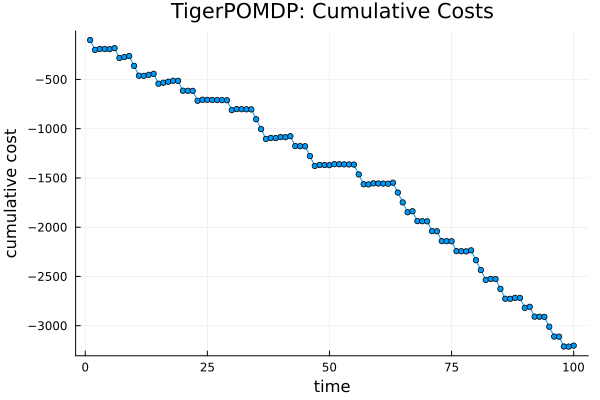

In [8]:
p = plot(1:T, rs_tiger, label=false, xlabel="time", ylabel="cumulative cost", markershape=:circle, markersize=3, title="TigerPOMDP: Cumulative Costs", size=(600,400))

#### POMDP Example 2: The Mountain Car


Info about this problem can be found on [wikipedia](https://en.wikipedia.org/wiki/Mountain_car_problem) and on [POMDPs.jl doc](https://juliapomdp.github.io/POMDPs.jl/stable/def_pomdp/#po-mountaincar). \
In our case, we add white noise to the state and observation models.

In [9]:
# Mountain Car POMDP Example

# Parameters
gravity = -0.0025
force = 0.001
goal = 0.5
σ_T = 0.0002
σ_O = 0.15

y(x) = sin(3x)/3 # mountain height function

mountaincar_pomdp = QuickPOMDP(
    actions = [-1.0, 0.0, 1.0], # acceleration action
    obstype = Float64,
    discount = 0.95,

    # define the complete generative function instead of each individual model:
    # Given the current true state and an action, outputs the next state, an observation and the reward.
    gen = function (s, a, rng = Random.default_rng)
        x, v = s
        vp = v + a*force + cos(3*x)*gravity + rand(rng, Normal(0, σ_T)) # velocity transition model for the mountain-car problem
        vp = clamp(vp, -0.07, 0.07) # trim to velocity limits
        xp = x + vp # position transition model for the mountain-car problem (deterministic given velocity)
        xp = clamp(xp, -1.2, 0.6) # trim to position limits
        if xp > goal
            r = 100.0
        else
            r = -abs(goal - xp)
        end
        o = xp + rand(rng, Normal(0, σ_O))
        return (sp=(xp, vp), o=o, r=r)
    end,

    initialstate = Deterministic((-0.5, 0.0)),
    isterminal = s -> s[1] > goal,
);

In [10]:
Random.seed!(0970252)

# Run the Mountain Car POMDP
T = 300
x_0 = -0.5
v_0 = 0.0

global s = rand(initialstate(mountaincar_pomdp))
rs_random = []
r_cumul = 0.0
anim = @animate for t in 1:T
    global s = s
    if s[1] > goal # break if reached a terminal state
        break
    end
    a = rand(actions(mountaincar_pomdp))
    sp, o, r = @gen(:sp, :o, :r)(mountaincar_pomdp, s, a)
    @show t, s, a, sp, o, r

    s = sp
    global r_cumul += r
    push!(rs_random, r_cumul)

    p1 = plot(; xlim=(-1.2, 1.0), title="Mountain Car: step $t, action = $a", xlabel="Position", ylabel="Height", legend=:topleft)
    plot!(p1, x -> y(x), -1.2, 1.0, label="Mountain", color=:black)
    scatter!(p1, [s[1]], [y(s[1])], label="Car", color=:blue, markershape=:circle, markersize=6)
    scatter!(p1, [goal], [y(goal)], label="Goal", color=:green, markershape=:star, markersize=10)

    p2 = plot(rs_random[1:t], xlabel="time", ylabel="cumulative reward", label="random", title="Mountain Car: Cumulative Reward", xlims=[1, T], ylims=[-1.5T, 0])
    plot(p1, p2, layout=(2,1), size=(800,600))
end

(t, s, a, sp, o, r) = (1, (-0.5, 0.0), -1.0, (-0.5012125412734822, -0.0012125412734822893), -0.39884571802328384, -1.0012125412734822)
(t, s, a, sp, o, r) = (2, (-0.5012125412734822, -0.0012125412734822893), 1.0, (-0.5013526228203526, -0.0001400815468704047), -0.5105025255095997, -1.0013526228203526)
(t, s, a, sp, o, r) = (3, (-0.5013526228203526, -0.0001400815468704047), 1.0, (-0.5006206757640854, 0.0007319470562672477), -0.4782946186041149, -1.0006206757640854)
(t, s, a, sp, o, r) = (4, (-0.5006206757640854, 0.0007319470562672477), -1.0, (-0.5009427983262942, -0.00032212256220871973), -0.4922990375955506, -1.0009427983262942)
(t, s, a, sp, o, r) = (5, (-0.5009427983262942, -0.00032212256220871973), 1.0, (-0.5003855637359778, 0.0005572345903164405), -0.48810519320258605, -1.0003855637359778)
(t, s, a, sp, o, r) = (6, (-0.5003855637359778, 0.0005572345903164405), 0.0, (-0.4998377953325488, 0.000547768403428961), -0.5417866665146052, -0.9998377953325488)
(t, s, a, sp, o, r) = (7, (-0.49

Animation("C:\\Users\\moshi\\AppData\\Local\\Temp\\jl_0DlqaR", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000291.png", "000292.png", "000293.png", "000294.png", "000295.png", "000296.png", "000297.png", "000298.png", "000299.png", "000300.png"])

[ Info: Saved animation to D:\ANPL\0970252-pomdp\Tutorials\assets\mountaincar_pomdp_random.gif


Plots.AnimatedGif("D:\\ANPL\\0970252-pomdp\\Tutorials\\assets\\mountaincar_pomdp_random.gif")
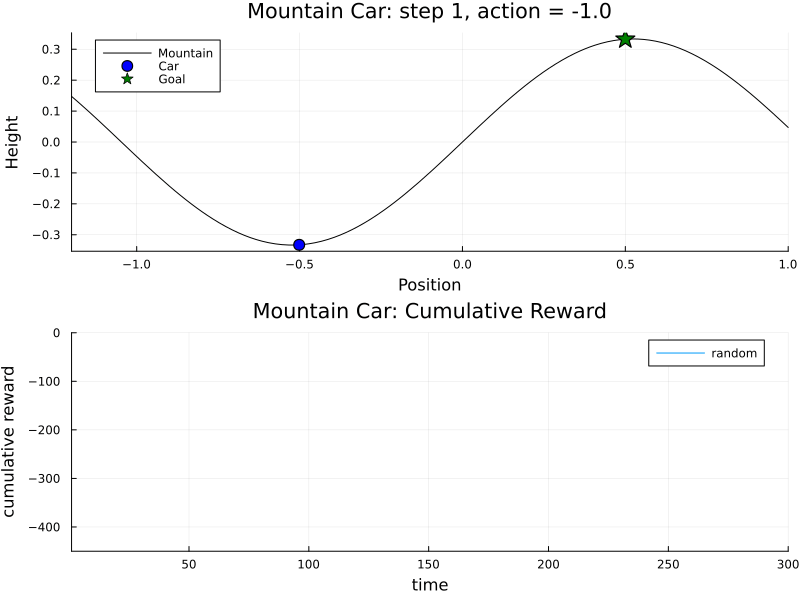

In [11]:
gif(anim, "./assets/mountaincar_pomdp_random.gif")

### Close Loop vs. Open Loop

---


#### Action Selection


**Open loop action:** actions/controls $a_{0:T−1}$ are determined _at once at time_ $0$ as a function of the initial state $X_0$ (MDP) or initial belief $b_0$ (POMDP).

**Closed loop (policy):** actions/controls are determined at each time $t$ _just-in-time_ as a _mapping_ $\pi_{t}$ between the current state $X_t$ (MDP), or history $H_t$, or belief $b_t$ (POMDP), to the actions.
$$
\pi_{0:T-1} = \{ \pi_0, \pi_1, ..., \pi_{T-1} \} \\
\begin{aligned}
    \text{MDP:  } & \pi_t : \mathcal{X} \to \mathcal{A} \\
    \text{POMDP:  } & \pi_t : \mathcal{\mathcal{H_t}} \to \mathcal{A} \text{\quad or \quad } & \pi_t : \mathcal{\mathcal{B_t}} \to \mathcal{A}
\end{aligned}
$$
When considering a _Stochastic_ policy, the mapping is to _a distribution over the actions_ $\Delta(\mathcal{A})$.

#### Evaluation

The agent's _performance_ is evaluated by the _cumulative reward_ of the actions they performed, which is formalized as the **_Return_**:
- Finite horizon $T$ case:
    $$
    \sum_{t=0}^{T-1} r(X_t, a_t) + r_{T}(X_T)
    $$
    ($r_{T}(X_{T})$ represents the terminal reward at the last state.)

- Discounted infinite-horizon case:
    $$
    \sum_{t=0}^{\infty} \gamma^t r(X_t, a_t)
    $$

#### Mountain-Car POMDP with open loop and close loop

In [12]:
Random.seed!(0970252)

# pre-defined action sequence
open_loop_actions = repeat([ones(25); -ones(25)], T÷50) # interchange accelerate right for 25 steps and accelerate left for 25 steps

global s = rand(initialstate(mountaincar_pomdp))
rs_open_loop = []
r_cumul = 0.0
anim = @animate for t in 1:T
    global s = s
    if s[1] > goal # break if reached a terminal state
        break
    end
    a = open_loop_actions[t]
    sp, o, r = @gen(:sp, :o, :r)(mountaincar_pomdp, s, a)
    @show t, s, a, sp, o, r

    s = sp
    global r_cumul += r
    push!(rs_open_loop, r_cumul)

    p1 = plot(; xlim=(-1.2, 1.0), title="Mountain Car: step $t, action = $a", xlabel="Position", ylabel="Height", legend=:topleft)
    plot!(p1, x -> y(x), -1.2, 1.0, label="Mountain", color=:black)
    scatter!(p1, [s[1]], [y(s[1])], label="Car", color=:blue, markershape=:circle, markersize=6)
    scatter!(p1, [goal], [y(goal)], label="Goal", color=:green, markershape=:star, markersize=10)

    p2 = plot(rs_open_loop[1:t], xlabel="time", ylabel="cumulative reward", label="open loop", title="Mountain Car: Cumulative Reward", xlims=[1, T], ylims=[-1.5T, 0])
    plot(p1, p2, layout=(2,1), size=(800,600))
end

(t, s, a, sp, o, r) = (1, (-0.5, 0.0), 1.0, (-0.49911898306201735, 0.0008810169379826524), -0.5258926850467913, -0.9991189830620173)
(t, s, a, sp, o, r) = (2, (-0.49911898306201735, 0.0008810169379826524), 1.0, (-0.4972849104800165, 0.0018340725820008739), -0.11301288319081876, -0.9972849104800166)
(t, s, a, sp, o, r) = (3, (-0.4972849104800165, 0.0018340725820008739), 1.0, (-0.4944077566706803, 0.0028771538093361896), -0.5035576593599274, -0.9944077566706804)
(t, s, a, sp, o, r) = (4, (-0.4944077566706803, 0.0028771538093361896), 1.0, (-0.4906535343206164, 0.0037542223500638804), -0.4683274771606459, -0.9906535343206164)
(t, s, a, sp, o, r) = (5, (-0.4906535343206164, 0.0037542223500638804), 1.0, (-0.48620996641082126, 0.004443567909795182), -0.39761271047280844, -0.9862099664108213)
(t, s, a, sp, o, r) = (6, (-0.48620996641082126, 0.004443567909795182), 1.0, (-0.48103470192527376, 0.005175264485547525), -0.8350940433232319, -0.9810347019252738)
(t, s, a, sp, o, r) = (7, (-0.481034701

Animation("C:\\Users\\moshi\\AppData\\Local\\Temp\\jl_Hgyq51", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000291.png", "000292.png", "000293.png", "000294.png", "000295.png", "000296.png", "000297.png", "000298.png", "000299.png", "000300.png"])

[ Info: Saved animation to D:\ANPL\0970252-pomdp\Tutorials\assets\mountaincar_pomdp_open_loop.gif


Plots.AnimatedGif("D:\\ANPL\\0970252-pomdp\\Tutorials\\assets\\mountaincar_pomdp_open_loop.gif")
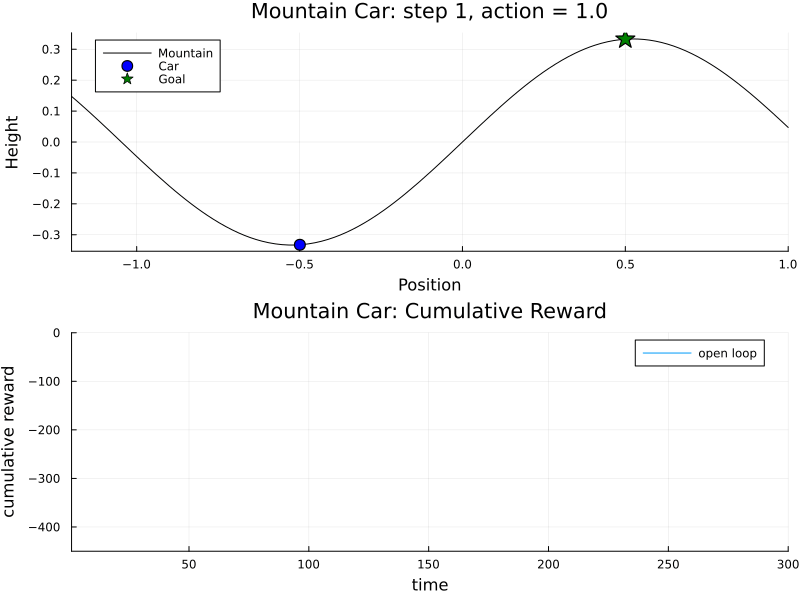

In [13]:
gif(anim, "./assets/mountaincar_pomdp_open_loop.gif")

In [14]:
Random.seed!(0970252)

# a pre-defined close loop action policy
function close_loop_policy(h)
    if length(h) <= 1
        return 1.0 # accelerate right if not enough observations
    else
        Δh = [h[t].o - h[t-1].o for t in 2:length(h)] # compute observed position changes
        return median(sign.(last(Δh, 5))) # accelerate in the direction of median observed position change
    end
end

global s = rand(initialstate(mountaincar_pomdp))
rs_close_loop = []
r_cumul = 0.0
mountaincar_history = []
anim = @animate for t in 1:T
    global s = s
    if s[1] > goal # break if reached a terminal state
        break
    end
    a = close_loop_policy(mountaincar_history)
    sp, o, r = @gen(:sp, :o, :r)(mountaincar_pomdp, s, a)
    @show t, s, a, sp, o, r

    s = sp
    global r_cumul += r
    push!(mountaincar_history, (o = o, a = a)) # add the new observation to the history
    push!(rs_close_loop, r_cumul)

    p1 = plot(; xlim=(-1.2, 1.0), title="Mountain Car: step $t, action = $a", xlabel="Position", ylabel="Height", legend=:topleft)
    plot!(p1, x -> y(x), -1.2, 1.0, label="Mountain", color=:black)
    scatter!(p1, [s[1]], [y(s[1])], label="Car", color=:blue, markershape=:circle, markersize=6)
    scatter!(p1, [goal], [y(goal)], label="Goal", color=:green, markershape=:star, markersize=10)

    p2 = plot(rs_close_loop[1:t], xlabel="time", ylabel="cumulative reward", label="close loop", title="Mountain Car: Cumulative Reward", xlims=[1, T], ylims=[-1.5T, 0])
    plot(p1, p2, layout=(2,1), size=(800,600))
end

(t, s, a, sp, o, r) = (1, (-0.5, 0.0), 1.0, (-0.49911898306201735, 0.0008810169379826524), -0.5258926850467913, -0.9991189830620173)
(t, s, a, sp, o, r) = (2, (-0.49911898306201735, 0.0008810169379826524), 1.0, (-0.4972849104800165, 0.0018340725820008739), -0.11301288319081876, -0.9972849104800166)
(t, s, a, sp, o, r) = (3, (-0.4972849104800165, 0.0018340725820008739), 1.0, (-0.4944077566706803, 0.0028771538093361896), -0.5035576593599274, -0.9944077566706804)
(t, s, a, sp, o, r) = (4, (-0.4944077566706803, 0.0028771538093361896), 0.0, (-0.4916535343206164, 0.0027542223500638804), -0.4693274771606459, -0.9916535343206164)
(t, s, a, sp, o, r) = (5, (-0.4916535343206164, 0.0027542223500638804), 1.0, (-0.4882025019139906, 0.003451032406625785), -0.3996052459759778, -0.9882025019139906)
(t, s, a, sp, o, r) = (6, (-0.4882025019139906, 0.003451032406625785), 1.0, (-0.48400491791351774, 0.004197584000472867), -0.8380642593114759, -0.9840049179135177)
(t, s, a, sp, o, r) = (7, (-0.484004917913

Animation("C:\\Users\\moshi\\AppData\\Local\\Temp\\jl_5O7DRQ", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000252.png", "000253.png", "000254.png", "000255.png", "000256.png", "000257.png", "000258.png", "000259.png", "000260.png", "000261.png"])

[ Info: Saved animation to D:\ANPL\0970252-pomdp\Tutorials\assets\mountaincar_pomdp_close_loop.gif


Plots.AnimatedGif("D:\\ANPL\\0970252-pomdp\\Tutorials\\assets\\mountaincar_pomdp_close_loop.gif")
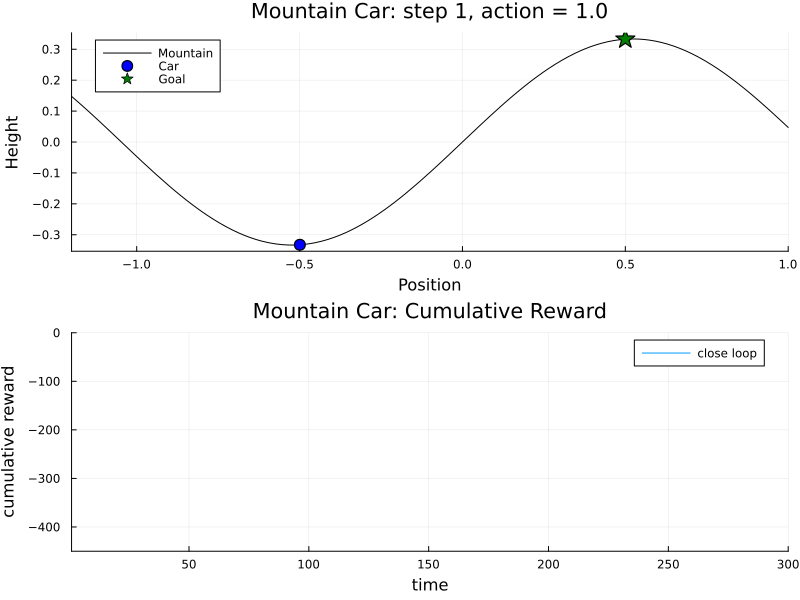

In [15]:
gif(anim, "./assets/mountaincar_pomdp_close_loop.gif")

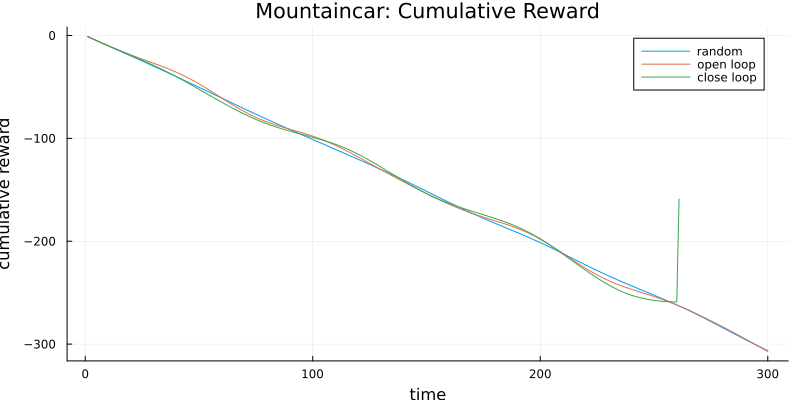

In [16]:
# plot cumulative rewards of all action selections together
plot(; title="Mountaincar: Cumulative Reward", xlabel="time", ylabel="cumulative reward", legend=:topright, size=(800,400))
plot!(rs_random, label="random")
plot!(rs_open_loop, label="open loop")
plot!(rs_close_loop, label="close loop")

#### <img width="48" height="48" src="https://img.icons8.com/bubbles/100/question-mark.png" alt="question-mark"/> Question

- Can you suggest a good policy for the Tiger POMDP?
- Can you suggest a good policy for the Mountain Car POMDP?
- If $X_0$ would not be given, but sampled randomly from some $b_0$ before each epoch, would your policies still be good?

### <img width="48" height="48" src="https://img.icons8.com/external-bearicons-outline-color-bearicons/64/external-copyright-graphic-design-bearicons-outline-color-bearicons.png" alt="external-copyright-graphic-design-bearicons-outline-color-bearicons"/> Credits

---

- Icons from [Icons8](https://icons8.com/)
